# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16|
import collections
import time
import math

# Import GEI dataset 

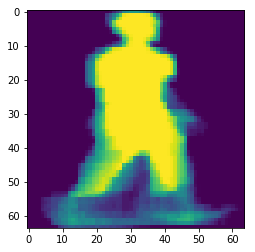

In [34]:
img = imread('{}'.format(os.path.join('OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)-15f/Seq00/0000024', '0000024_55_GEI_15f.png')))
img = imresize(img, [64, 64], interp='nearest')
plt.imshow(img)
plt.show()

In [45]:
# Create Training Data
path = 'OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)/Seq01'
Seq_15f_list = os.listdir(path)
Seq_15f_list.remove('.DS_Store')

Seq = []
for each_seq in Seq_15f_list:
    seq_path = os.path.join(path, each_seq)
    GEI = []
    for each_GEI in os.listdir(seq_path):
        img = imread('{}'.format(os.path.join(seq_path, each_GEI)))
        img = imresize(img, [64, 64], interp='nearest')
        GEI.append(img)
    Seq.append(np.array(GEI))
Seq = np.array(Seq)

In [46]:
with open('../gait_data/OULP_GEI/codes', 'wb') as f:
    np.save(f, Seq)

# Checkpoint 1

In [2]:
# gallery_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq00', mode='rb'))
# probe_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq01', mode='rb'))
gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq00', mode='rb'))
probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq01', mode='rb'))

In [3]:
gallery_full = gallery_full/float(255)
probe_full = probe_full/float(255)

<br><br><br><br><br><br><br><br><br>

# Auto_Encoder 2: 65''-75''
### 先试full-full

In [4]:
# Train X
train_x = np.concatenate([gallery_full[:2500, 1], probe_full[:2500, 1]], axis=0)
train_x = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
# Train Y
train_y = np.concatenate([gallery_full[:2500, 2], probe_full[:2500, 2]], axis=0)
train_y = np.reshape(train_y, [train_y.shape[0], train_y.shape[1], train_y.shape[2], 1])
print('train_x', train_x.shape, 'train_y', train_y.shape)

# Val X
val_x = gallery_full[2500:, 1]
val_x = np.reshape(val_x, [val_x.shape[0], val_x.shape[1], val_x.shape[2], 1])
# Val Y
val_y = gallery_full[2500:, 2]
val_y = np.reshape(val_y, [val_y.shape[0], val_y.shape[1], val_y.shape[2], 1])
print('val_x', val_x.shape, 'val_y', val_y.shape)

# Test X
test_x = probe_full[2500:, 1]
test_x = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
# Test Y
test_y = probe_full[2500:, 2]
test_y = np.reshape(test_y, [test_y.shape[0], test_y.shape[1], test_y.shape[2], 1])
print('test_x', test_x.shape, 'test_y', test_y.shape)

train_x (5000, 64, 64, 1) train_y (5000, 64, 64, 1)
val_x (646, 64, 64, 1) val_y (646, 64, 64, 1)
test_x (646, 64, 64, 1) test_y (646, 64, 64, 1)


# Create Graph

In [5]:
def build_inputs_outputs():
    inputs_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='inputs_1')
    targets_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='targets_1')
    
    return inputs_1, targets_1

def conv_layer(inputs_, weights_name, bias_name, conv_name, pool_name, bn_name, relu_name, add_bacth_norm=True, is_training=True, 
               set_stddev=0.03, out_dim=1, conv_kernsize=(2,2), conv_strides=(1,1), pool_size=(2,2), pool_strides=(2,2), 
               keep_prob=0.5):
    ### Encoder
    # e.g. out_dim: 8; kern_size: (3,3); pool_size: (2,2); strides: (2,2);
        
    # filter:[filter_height, filter_width, in_channels, out_channels]
    weight = tf.Variable(tf.truncated_normal([conv_kernsize[0],conv_kernsize[1],\
                         inputs_.get_shape().as_list()[3], out_dim], stddev=set_stddev),\
                         name=weights_name) 
    
    # Set bias
    bias = tf.Variable(tf.zeros(out_dim), name=bias_name)
    
    # set strides of conv2d
    stride = [1, conv_strides[0], conv_strides[1], 1]
    
    # conv2d
    # input:[batch, in_height, in_width, in_channels]
    conv2d = tf.nn.bias_add(tf.nn.conv2d(inputs_, weight, stride, padding='SAME', name=conv_name), bias)
    
    # Now 28x28x
    if add_bacth_norm:
        conv2d = tf.layers.batch_normalization(conv2d, training=is_training, name=bn_name)
        
    # add activation function
    conv2d = tf.nn.relu(conv2d, name=relu_name)
    
    # add Max pooling
    conv2d_maxpool = tf.nn.max_pool(conv2d, [1,pool_size[0],pool_size[1],1],\
                                    [1,pool_strides[0],pool_strides[1],1], padding='SAME', name=pool_name)
                    
    conv2d_maxpool = tf.layers.dropout(conv2d_maxpool, rate=keep_prob)

    return conv2d_maxpool

#     # Now 14x14x16
#     conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
#     # Now 7x7x8
#     conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 7x7x8
#     encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
#     # Now 4x4x8

def deconv_layer(encoded, up_name, weights_name, bias_name, de_conv_name, bn_name, relu_name, add_batch_norm=True, is_training=True, 
                 set_stddev=0.03, up_size=[(2,2),(4,4),(5,5),(6,6)], out_dim=1, conv_kernsize=(2,2), conv_strides=(1,1), keep_prob=0.5):
    ### Decoder
    upsample = tf.image.resize_nearest_neighbor(encoded, up_size, name=up_name) # up_size: e.g.(7,7)
    
    # set weight (filter)
    weight = tf.Variable(tf.truncated_normal([conv_kernsize[0],conv_kernsize[1],\
                         upsample.get_shape().as_list()[3], out_dim], stddev=set_stddev),\
                         name=weights_name)
    
    # set bias
    bias = tf.Variable(tf.zeros(out_dim), name=bias_name)
    
    # set strides of conv2d
    stride = [1, conv_strides[0], conv_strides[1], 1]
    
    # conv2d
    conv2d = tf.nn.bias_add(tf.nn.conv2d(upsample, weight, stride, padding='SAME', name=de_conv_name),\
                   bias)
    
    if add_batch_norm:
        conv2d = tf.layers.batch_normalization(conv2d, training=is_training, name=bn_name)
    
    conv2d = tf.nn.relu(conv2d, name=relu_name)
    
    conv2d = tf.layers.dropout(conv2d, rate=keep_prob)
    
    return conv2d

#     # Now 7x7x8
#     upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
#     # Now 14x14x8
#     conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
#     # Now 28x28x8
#     conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 28x28x16

def output_layer(conv2d, weights_name, bias_name, logits_name, bn_name, decoded_name, add_batch_norm=True, is_training=True, 
                 set_stddev=0.03, out_dim=1, conv_kernsize=(3,3), conv_strides=(1,1)):
    # set weight (filter)
    weight = tf.Variable(tf.truncated_normal([conv_kernsize[0],conv_kernsize[1],\
                         conv2d.get_shape().as_list()[3], out_dim], stddev=set_stddev),\
                         name=weights_name)
    
    # set bias
    bias = tf.Variable(tf.zeros(out_dim), name=bias_name)
    
    # set strides of conv2d
    stride = [1, conv_strides[0], conv_strides[1], 1]
    
    # conv2d
    logits = tf.nn.bias_add(tf.nn.conv2d(conv2d, weight, stride, padding='SAME', name=logits_name),\
                   bias)
    
    if add_batch_norm:
        conv2d = tf.layers.batch_normalization(conv2d, training=is_training, name=bn_name)
    #Now 28x28x1
    decoded = tf.nn.sigmoid(logits, name=decoded_name)
    
    return logits, decoded

In [21]:
def build_graph(kern_size, std, conv_strides, pool_size, pool_strides, de_kern_size, 
                de_conv_strides, out_kern_size, out_strides, up_size=[(16,16), (32,32), (64,64)]):
    
    # reset graph
    tf.reset_default_graph()
    
    with tf.name_scope('inputs_targets'):
        inputs_1, targets_1 = build_inputs_outputs()
    
    keep_p = tf.placeholder(tf.float32, name="keep_prob")
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    training = tf.placeholder(tf.bool, name='training')
    
    with tf.name_scope('conv_layers'):
        
        maxpool_1 = conv_layer(inputs_1, 'conv_weights_1', 'bias_1', 'conv_1', 'pool_1', 'bn_1', 'relu_1', add_bacth_norm=False, 
                               is_training=training, set_stddev=std, out_dim=16, conv_kernsize=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_2 = conv_layer(maxpool_1, 'conv_weights_2', 'bias_2', 'conv_2', 'pool_2', 'bn_2', 'relu_2', add_bacth_norm=True, 
                               is_training=training, set_stddev=std, out_dim=32, conv_kernsize=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
#         maxpool_3 = conv_layer(maxpool_2, 'conv_weights_3', 'bias_2', 'conv_3', 'pool_3', 'bn_3', 'relu_3', add_bacth_norm=True, 
#                                is_training=training, set_stddev=std, out_dim=8, conv_kernsize=kern_size, conv_strides=conv_strides, 
#                                pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
#         maxpool_4 = conv_layer(maxpool_3, 'conv_weights_4', 'conv_4', 'pool_4', 'bn_4', 'relu_4', add_bacth_norm=True, 
#                                is_training=set_is_training, set_stddev=std, out_dim=8, conv_kernsize=kern_size, conv_strides=conv_strides, 
#                                pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        # Now 4x4x8 as hidden layer
        
    with tf.name_scope('deconv_layers'):
        
        deconv_1 = deconv_layer(maxpool_2, 'up_1', 'deconv_weights_1', 'debias_1', 'deconv_1', 'de_bn_1', 'de_relu_1', add_batch_norm=True, 
                              is_training=training, set_stddev=std, up_size=up_size[0], out_dim=32, conv_kernsize=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_2 = deconv_layer(deconv_1, 'up_2', 'deconv_weights_2', 'debias_2', 'deconv_2', 'de_bn_2', 'de_relu_2', add_batch_norm=True, 
                              is_training=training, set_stddev=std, up_size=up_size[1], out_dim=16, conv_kernsize=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
#         deconv_3 = deconv_layer(deconv_2, 'up_3', 'deconv_weights_3', 'debias_2', 'deconv_3', 'de_bn_3', 'de_relu_3', add_batch_norm=True, 
#                               is_training=training, set_stddev=std, up_size=up_size[2], out_dim=32, conv_kernsize=de_kern_size,
#                               conv_strides=de_conv_strides, keep_prob=keep_p)
        
#         deconv_4 = deconv_layer(deconv_3, 'up_4', 'deconv_weights_4', 'deconv_4', 'de_bn_4', 'de_relu_4', add_batch_norm=True, 
#                               is_training=set_is_training, set_stddev=std, up_size=up_size[3], out_dim=16, conv_kernsize=de_kern_size,
#                               conv_strides=de_conv_strides, keep_prob=keep_p)
        
    with tf.name_scope('output_layer'):
       
        logits, decoded = output_layer(deconv_2, 'output_weights', 'outbias_1', 'logits', 'bn', 'decoded', add_batch_norm=True, is_training=training, 
                                       set_stddev=std, out_dim=1, conv_kernsize=out_kern_size, conv_strides=out_strides)
        
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_1, logits=logits, name='loss')
    cost = tf.reduce_mean(loss, name='cost')
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('saver'):
        saver = tf.train.Saver()
        
#     merged = tf.summary.merge_all()
    
    export_nodes = ['inputs_1', 'targets_1', 'maxpool_1', 'maxpool_2', 'deconv_1', 'deconv_2', 'training',
                    'logits', 'decoded', 'loss', 'cost', 'opt', 'saver', 'learning_rate', 'keep_p']
    
    Graph = collections.namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [17]:
def get_batches(data, target, batch_size):
    n_batches = len(data)//batch_size
    data = data[:batch_size * n_batches]
    target = target[:batch_size * n_batches]
    for ii in range(0, batch_size*n_batches, batch_size):
        data_batch = data[ii:ii + batch_size]
        target_batch = target[ii:ii + batch_size]
        
        yield data_batch, target_batch
        
        
def cal_accuracy(decoded, target):
    error = abs(decoded - target)
    Acc = (np.sum(error <= 0.08)/(decoded.shape[0]*decoded.shape[1]*decoded.shape[2]*decoded.shape[3]))*100
    
    return Acc

In [18]:
error = np.random.rand(10,5,5,1)
np.sum(error >= 0.9)/100

0.28999999999999998

In [22]:
def train(model, epochs, save_string):

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        
        iteration = 1
        mean_val_loss = 0
        mean_val_acc = 0
        count_loss_not_decrease_epochs = 0
        count_acc_not_decrease_epochs = 0
        Last_val_loss = 0
        Last_val_acc = 0
        
        
        for e in range(epochs):
            for train_batch, target_batch in get_batches(train_x, train_y, batch_size):
                    
                start = time.time()
                
                feed_1 = {
                        model.inputs_1: train_batch, 
                        model.targets_1: target_batch,
                        model.keep_p: 0.6,
                        model.learning_rate: lr,
                        model.training:True
                        }

                train_loss, _, decoded_img = sess.run([model.cost, model.opt, model.decoded], feed_dict=feed_1)
                
                train_acc = cal_accuracy(decoded_img, target_batch)
                
                if iteration%25==0:
                    end = time.time()
#                     acc = calculate_accuracy(sess, pred, target_batch, sq_length)
                    print("Epoch: {}/{},".format(e+1, epochs),' '
                          "Iteration: {},".format(iteration),' '
                          "Train loss: {:.3f},".format(train_loss),'      '
                          "{:.1f}s /batch.".format((end-start)/5),' '
                          "Train Accuracy: %{:.3f}".format(train_acc))

                ##############################################################
                ######################## VALIDATION ##########################
                ##############################################################
                
                if iteration%75==0:
#                     training = True
                    validation_loss = []
                    validation_acc = []
                    
                    if batch_size >= len(val_x):
                        val_batch_size = len(val_x)
                    else: 
                        val_batch_size = batch_size
                        

                    for ii, (val_batch, val_target_batch) in enumerate(get_batches(val_x, val_y, val_batch_size)):
#                         print(ii, len(val_x)//val_batch_size)
                        feed_2 = {
                                model.inputs_1: val_batch,
                                model.targets_1: val_target_batch,
                                model.keep_p: 1,
                                model.training:True
                                }
                        
                        val_loss, val_decoded_img = sess.run([model.cost, model.decoded], 
                                                                          feed_dict=feed_2)

                        val_acc = cal_accuracy(val_decoded_img, val_target_batch)
                        
                        validation_loss.append(val_loss)
                        validation_acc.append(val_acc)
                    
                    Last_val_loss = mean_val_loss
                    Last_val_acc = mean_val_acc
                    mean_val_loss = np.mean(np.array(validation_loss))
                    mean_val_acc = np.mean(np.array(validation_acc))
                    
                    print()
                    print("Validation loss: {:.3f},".format(mean_val_loss),' '
                          "Validation accuracy: {:.3f},".format(mean_val_acc))
#                           "maxpool_3.shape: {}.".format(max_pool_3[0].shape))
                    print()
                ####### plot #######
                if iteration%500==0:
                    
                    feed_3 = {
                            model.inputs_1: val_x[:10],
                            model.keep_p: 1,
                            model.training:True
                            }
                    
                    fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))
                    in_imgs = val_x[:10]
                    reconstructed = sess.run(model.decoded, feed_dict=feed_3)
                    targets = val_y[:10]
                    # plot out
                    for images, row in zip([in_imgs, targets, reconstructed], axes):
                        for img, ax in zip(images, row):
                            ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
                            ax.get_xaxis().set_visible(False)
                            ax.get_yaxis().set_visible(False)



                    fig.tight_layout(pad=0.1)
                            
                    
                    
                    
                    
                iteration += 1
                
#             # Early stopping  
#             if mean_val_Acc - Last_val_Acc <= -0.3:
#                 count_Acc_not_increase_epochs += 1
#             if Last_val_loss - mean_val_loss <= -0.01:
#                 count_loss_not_decrease_epochs += 1
                
#             if mean_val_Acc - Last_val_Acc <= -2:
#                 break
#             if count_Acc_not_increase_epochs >= 10:
#                 break
#             if count_loss_not_decrease_epochs >= 10:
#                 break
                
        model.saver.save(sess, r"{}".format(save_string))

mkdir: cannot create directory ‘checkpoints_view_invariant’: File exists
Epoch: 1/400,  Iteration: 25,  Train loss: 0.283,       0.0s /batch.  Train Accuracy: %29.843
Epoch: 1/400,  Iteration: 50,  Train loss: 0.227,       0.0s /batch.  Train Accuracy: %79.308
Epoch: 2/400,  Iteration: 75,  Train loss: 0.206,       0.0s /batch.  Train Accuracy: %86.801

Validation loss: 0.208,  Validation accuracy: 84.709,

Epoch: 2/400,  Iteration: 100,  Train loss: 0.210,       0.0s /batch.  Train Accuracy: %87.313
Epoch: 3/400,  Iteration: 125,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %88.507
Epoch: 3/400,  Iteration: 150,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %90.482

Validation loss: 0.199,  Validation accuracy: 90.152,

Epoch: 3/400,  Iteration: 175,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %89.702
Epoch: 4/400,  Iteration: 200,  Train loss: 0.201,       0.0s /batch.  Train Accuracy: %90.443
Epoch: 4/400,  Iteration: 225,  Train loss: 0.203,       0

Epoch: 30/400,  Iteration: 1825,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %92.488
Epoch: 30/400,  Iteration: 1850,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %92.835
Epoch: 31/400,  Iteration: 1875,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %92.351

Validation loss: 0.195,  Validation accuracy: 92.029,

Epoch: 31/400,  Iteration: 1900,  Train loss: 0.206,       0.0s /batch.  Train Accuracy: %92.760
Epoch: 32/400,  Iteration: 1925,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %92.833
Epoch: 32/400,  Iteration: 1950,  Train loss: 0.188,       0.0s /batch.  Train Accuracy: %93.617

Validation loss: 0.194,  Validation accuracy: 93.121,

Epoch: 32/400,  Iteration: 1975,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %92.496
Epoch: 33/400,  Iteration: 2000,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %92.828
Epoch: 33/400,  Iteration: 2025,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %92.869

Validation los

Epoch: 59/400,  Iteration: 3625,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %92.899
Epoch: 59/400,  Iteration: 3650,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %92.986
Epoch: 60/400,  Iteration: 3675,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %93.246

Validation loss: 0.194,  Validation accuracy: 92.930,

Epoch: 60/400,  Iteration: 3700,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %93.185
Epoch: 61/400,  Iteration: 3725,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %92.929
Epoch: 61/400,  Iteration: 3750,  Train loss: 0.191,       0.0s /batch.  Train Accuracy: %93.961

Validation loss: 0.193,  Validation accuracy: 93.317,

Epoch: 61/400,  Iteration: 3775,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %93.027
Epoch: 62/400,  Iteration: 3800,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %92.723
Epoch: 62/400,  Iteration: 3825,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %93.323

Validation los

Epoch: 88/400,  Iteration: 5425,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.262
Epoch: 88/400,  Iteration: 5450,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.535
Epoch: 89/400,  Iteration: 5475,  Train loss: 0.191,       0.0s /batch.  Train Accuracy: %93.252

Validation loss: 0.193,  Validation accuracy: 93.354,

Epoch: 89/400,  Iteration: 5500,  Train loss: 0.191,       0.0s /batch.  Train Accuracy: %93.605
Epoch: 90/400,  Iteration: 5525,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %93.963
Epoch: 90/400,  Iteration: 5550,  Train loss: 0.189,       0.0s /batch.  Train Accuracy: %93.463

Validation loss: 0.193,  Validation accuracy: 93.434,

Epoch: 90/400,  Iteration: 5575,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %93.817
Epoch: 91/400,  Iteration: 5600,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %93.971
Epoch: 91/400,  Iteration: 5625,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %93.575

Validation los

Epoch: 117/400,  Iteration: 7200,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %93.927

Validation loss: 0.194,  Validation accuracy: 93.221,

Epoch: 117/400,  Iteration: 7225,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %93.234
Epoch: 117/400,  Iteration: 7250,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %93.054
Epoch: 118/400,  Iteration: 7275,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.857

Validation loss: 0.193,  Validation accuracy: 93.309,

Epoch: 118/400,  Iteration: 7300,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %94.021
Epoch: 119/400,  Iteration: 7325,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %93.509
Epoch: 119/400,  Iteration: 7350,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %93.179

Validation loss: 0.193,  Validation accuracy: 93.401,

Epoch: 119/400,  Iteration: 7375,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %94.073
Epoch: 120/400,  Iteration: 7400,  Train loss: 0

Epoch: 145/400,  Iteration: 8950,  Train loss: 0.190,       0.0s /batch.  Train Accuracy: %93.808
Epoch: 145/400,  Iteration: 8975,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.610
Epoch: 146/400,  Iteration: 9000,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.355

Validation loss: 0.193,  Validation accuracy: 93.366,

Epoch: 146/400,  Iteration: 9025,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %93.499
Epoch: 146/400,  Iteration: 9050,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.546
Epoch: 147/400,  Iteration: 9075,  Train loss: 0.193,       0.0s /batch.  Train Accuracy: %93.568

Validation loss: 0.193,  Validation accuracy: 93.369,

Epoch: 147/400,  Iteration: 9100,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %93.502
Epoch: 148/400,  Iteration: 9125,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %93.691
Epoch: 148/400,  Iteration: 9150,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %92.281

Valid

/usr/home/rez/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch: 170/400,  Iteration: 10525,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.632
Epoch: 171/400,  Iteration: 10550,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.422
Epoch: 171/400,  Iteration: 10575,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %93.619

Validation loss: 0.193,  Validation accuracy: 93.292,

Epoch: 171/400,  Iteration: 10600,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.601
Epoch: 172/400,  Iteration: 10625,  Train loss: 0.193,       0.0s /batch.  Train Accuracy: %93.645
Epoch: 172/400,  Iteration: 10650,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %93.553

Validation loss: 0.193,  Validation accuracy: 93.537,

Epoch: 173/400,  Iteration: 10675,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %93.802
Epoch: 173/400,  Iteration: 10700,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %92.292
Epoch: 173/400,  Iteration: 10725,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %93.5

Epoch: 198/400,  Iteration: 12275,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %93.623
Epoch: 199/400,  Iteration: 12300,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.561

Validation loss: 0.193,  Validation accuracy: 93.511,

Epoch: 199/400,  Iteration: 12325,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %93.733
Epoch: 200/400,  Iteration: 12350,  Train loss: 0.193,       0.0s /batch.  Train Accuracy: %93.665
Epoch: 200/400,  Iteration: 12375,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.658

Validation loss: 0.193,  Validation accuracy: 93.396,

Epoch: 200/400,  Iteration: 12400,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.933
Epoch: 201/400,  Iteration: 12425,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %93.621
Epoch: 201/400,  Iteration: 12450,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %93.622

Validation loss: 0.193,  Validation accuracy: 93.484,

Epoch: 202/400,  Iteration: 12475,  Trai

Epoch: 227/400,  Iteration: 14025,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %93.507

Validation loss: 0.193,  Validation accuracy: 93.544,

Epoch: 227/400,  Iteration: 14050,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %93.724
Epoch: 228/400,  Iteration: 14075,  Train loss: 0.189,       0.0s /batch.  Train Accuracy: %93.955
Epoch: 228/400,  Iteration: 14100,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %94.226

Validation loss: 0.193,  Validation accuracy: 93.613,

Epoch: 228/400,  Iteration: 14125,  Train loss: 0.189,       0.0s /batch.  Train Accuracy: %94.048
Epoch: 229/400,  Iteration: 14150,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %93.452
Epoch: 229/400,  Iteration: 14175,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %93.661

Validation loss: 0.193,  Validation accuracy: 93.461,

Epoch: 230/400,  Iteration: 14200,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %93.979
Epoch: 230/400,  Iteration: 14225,  Trai

Epoch: 255/400,  Iteration: 15775,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %93.315
Epoch: 255/400,  Iteration: 15800,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.783
Epoch: 256/400,  Iteration: 15825,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %94.120

Validation loss: 0.194,  Validation accuracy: 93.177,

Epoch: 256/400,  Iteration: 15850,  Train loss: 0.205,       0.0s /batch.  Train Accuracy: %93.523
Epoch: 257/400,  Iteration: 15875,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %93.835
Epoch: 257/400,  Iteration: 15900,  Train loss: 0.187,       0.0s /batch.  Train Accuracy: %94.453

Validation loss: 0.193,  Validation accuracy: 93.619,

Epoch: 257/400,  Iteration: 15925,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %93.431
Epoch: 258/400,  Iteration: 15950,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %94.087
Epoch: 258/400,  Iteration: 15975,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %93.5

Epoch: 283/400,  Iteration: 17525,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %93.641
Epoch: 284/400,  Iteration: 17550,  Train loss: 0.201,       0.0s /batch.  Train Accuracy: %93.814

Validation loss: 0.193,  Validation accuracy: 93.461,

Epoch: 284/400,  Iteration: 17575,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.436
Epoch: 284/400,  Iteration: 17600,  Train loss: 0.193,       0.0s /batch.  Train Accuracy: %93.492
Epoch: 285/400,  Iteration: 17625,  Train loss: 0.191,       0.0s /batch.  Train Accuracy: %94.322

Validation loss: 0.193,  Validation accuracy: 93.527,

Epoch: 285/400,  Iteration: 17650,  Train loss: 0.201,       0.0s /batch.  Train Accuracy: %93.523
Epoch: 286/400,  Iteration: 17675,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %93.576
Epoch: 286/400,  Iteration: 17700,  Train loss: 0.190,       0.0s /batch.  Train Accuracy: %94.528

Validation loss: 0.193,  Validation accuracy: 93.673,

Epoch: 286/400,  Iteration: 17725,  Trai

Epoch: 311/400,  Iteration: 19275,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %93.622

Validation loss: 0.193,  Validation accuracy: 93.617,

Epoch: 312/400,  Iteration: 19300,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %93.552
Epoch: 312/400,  Iteration: 19325,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %94.164
Epoch: 313/400,  Iteration: 19350,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %94.256

Validation loss: 0.193,  Validation accuracy: 93.358,

Epoch: 313/400,  Iteration: 19375,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.801
Epoch: 313/400,  Iteration: 19400,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %93.945
Epoch: 314/400,  Iteration: 19425,  Train loss: 0.190,       0.0s /batch.  Train Accuracy: %93.822

Validation loss: 0.193,  Validation accuracy: 93.586,

Epoch: 314/400,  Iteration: 19450,  Train loss: 0.191,       0.0s /batch.  Train Accuracy: %94.270
Epoch: 315/400,  Iteration: 19475,  Trai

Epoch: 340/400,  Iteration: 21025,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %94.367
Epoch: 340/400,  Iteration: 21050,  Train loss: 0.188,       0.0s /batch.  Train Accuracy: %93.868
Epoch: 340/400,  Iteration: 21075,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %94.180

Validation loss: 0.193,  Validation accuracy: 93.667,

Epoch: 341/400,  Iteration: 21100,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %94.376
Epoch: 341/400,  Iteration: 21125,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %94.270
Epoch: 342/400,  Iteration: 21150,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %94.132

Validation loss: 0.193,  Validation accuracy: 93.386,

Epoch: 342/400,  Iteration: 21175,  Train loss: 0.198,       0.0s /batch.  Train Accuracy: %93.654
Epoch: 342/400,  Iteration: 21200,  Train loss: 0.196,       0.0s /batch.  Train Accuracy: %93.313
Epoch: 343/400,  Iteration: 21225,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %94.1

Epoch: 368/400,  Iteration: 22775,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %94.075
Epoch: 368/400,  Iteration: 22800,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %94.497

Validation loss: 0.193,  Validation accuracy: 93.292,

Epoch: 369/400,  Iteration: 22825,  Train loss: 0.204,       0.0s /batch.  Train Accuracy: %93.988
Epoch: 369/400,  Iteration: 22850,  Train loss: 0.200,       0.0s /batch.  Train Accuracy: %93.456
Epoch: 369/400,  Iteration: 22875,  Train loss: 0.191,       0.0s /batch.  Train Accuracy: %94.331

Validation loss: 0.193,  Validation accuracy: 93.653,

Epoch: 370/400,  Iteration: 22900,  Train loss: 0.190,       0.0s /batch.  Train Accuracy: %94.187
Epoch: 370/400,  Iteration: 22925,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %94.077
Epoch: 371/400,  Iteration: 22950,  Train loss: 0.195,       0.0s /batch.  Train Accuracy: %93.683

Validation loss: 0.193,  Validation accuracy: 93.490,

Epoch: 371/400,  Iteration: 22975,  Trai

Epoch: 396/400,  Iteration: 24525,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %93.908

Validation loss: 0.193,  Validation accuracy: 93.451,

Epoch: 396/400,  Iteration: 24550,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %93.954
Epoch: 397/400,  Iteration: 24575,  Train loss: 0.192,       0.0s /batch.  Train Accuracy: %94.052
Epoch: 397/400,  Iteration: 24600,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %93.793

Validation loss: 0.193,  Validation accuracy: 93.576,

Epoch: 398/400,  Iteration: 24625,  Train loss: 0.197,       0.0s /batch.  Train Accuracy: %94.101
Epoch: 398/400,  Iteration: 24650,  Train loss: 0.202,       0.0s /batch.  Train Accuracy: %92.554
Epoch: 398/400,  Iteration: 24675,  Train loss: 0.199,       0.0s /batch.  Train Accuracy: %93.695

Validation loss: 0.193,  Validation accuracy: 93.669,

Epoch: 399/400,  Iteration: 24700,  Train loss: 0.194,       0.0s /batch.  Train Accuracy: %93.762
Epoch: 399/400,  Iteration: 24725,  Trai

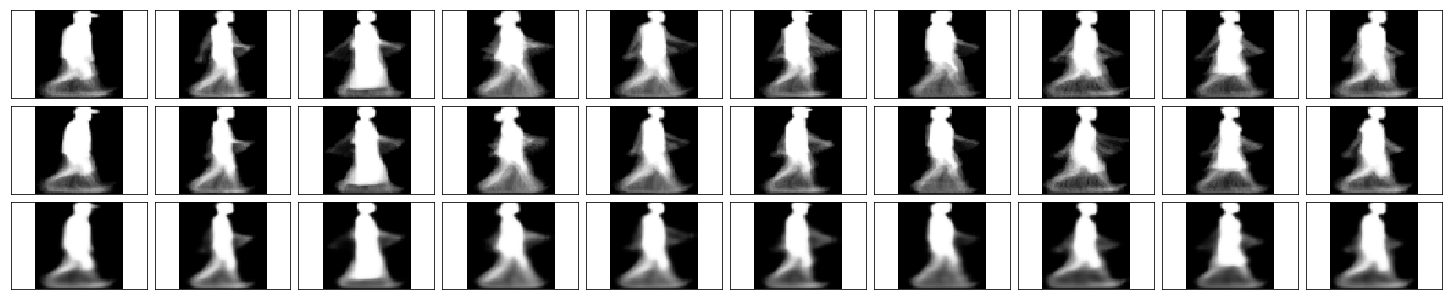

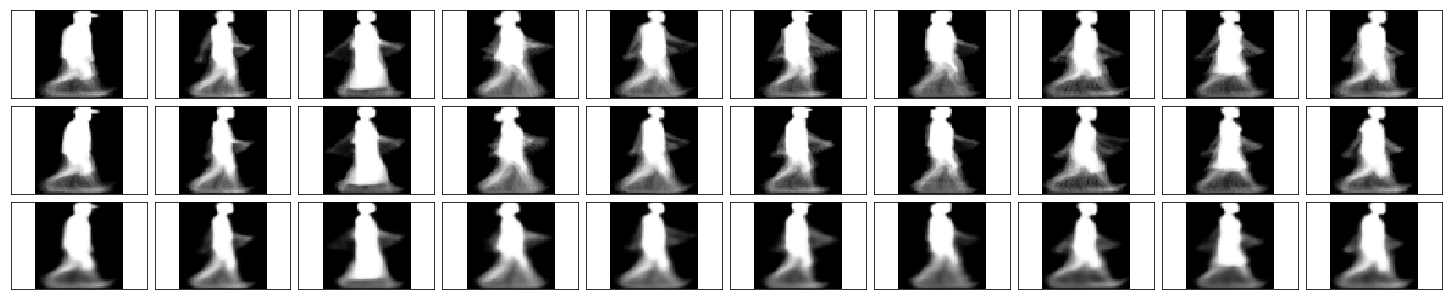

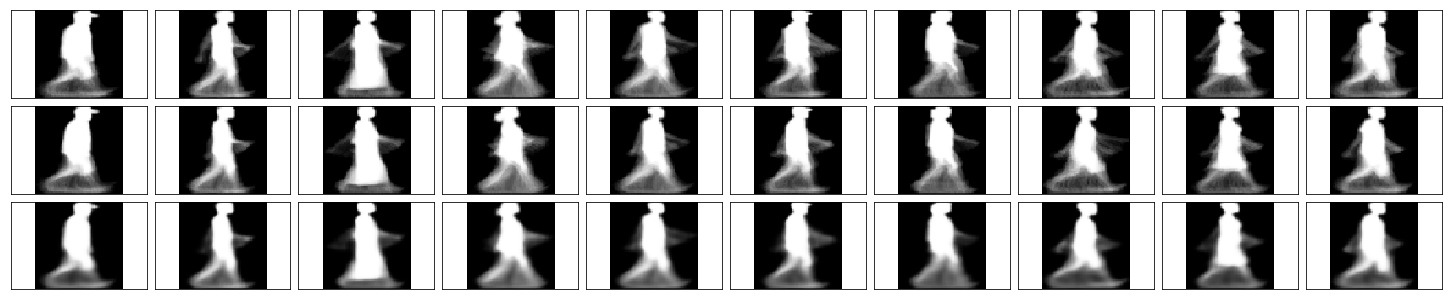

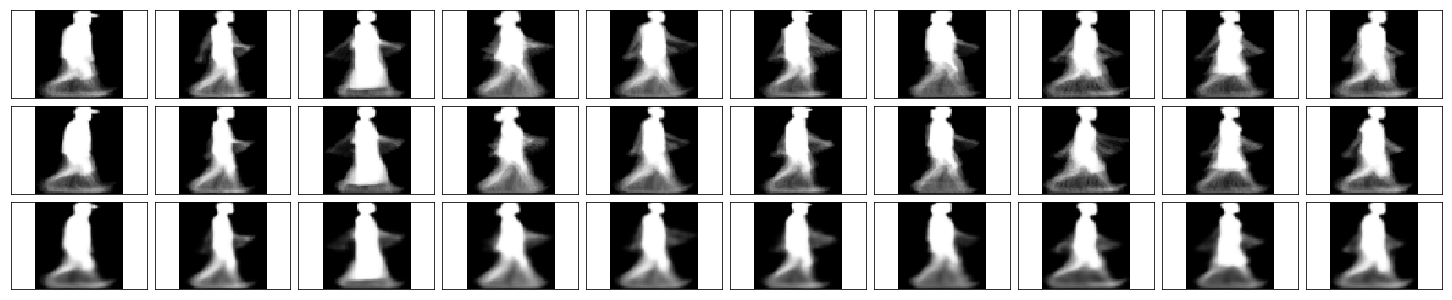

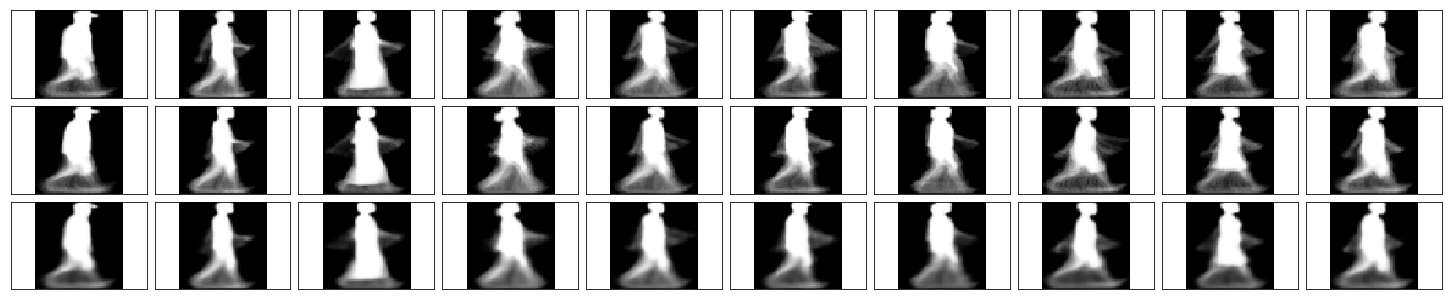

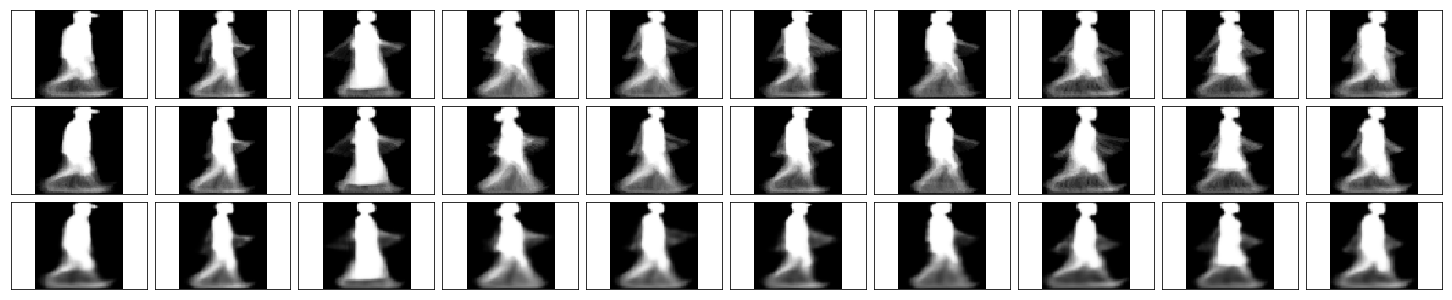

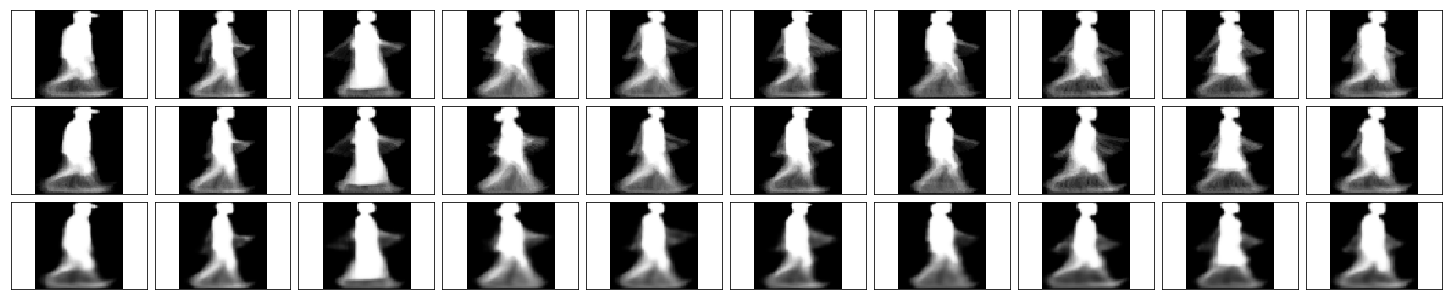

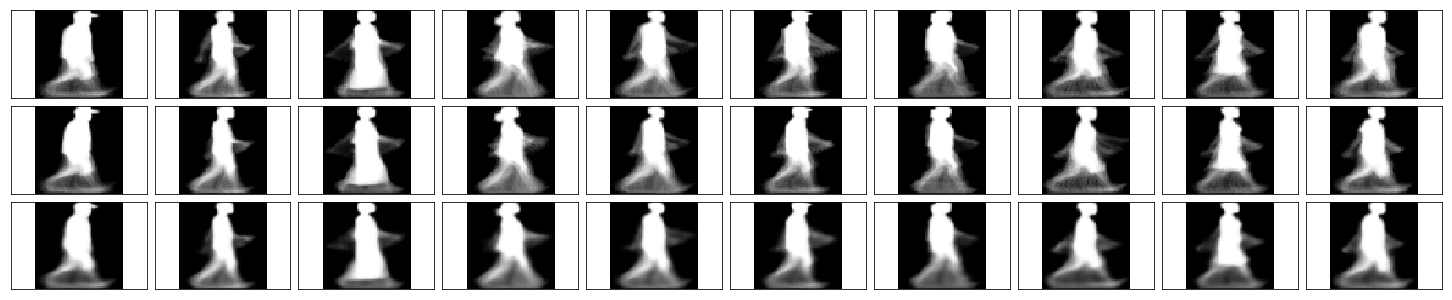

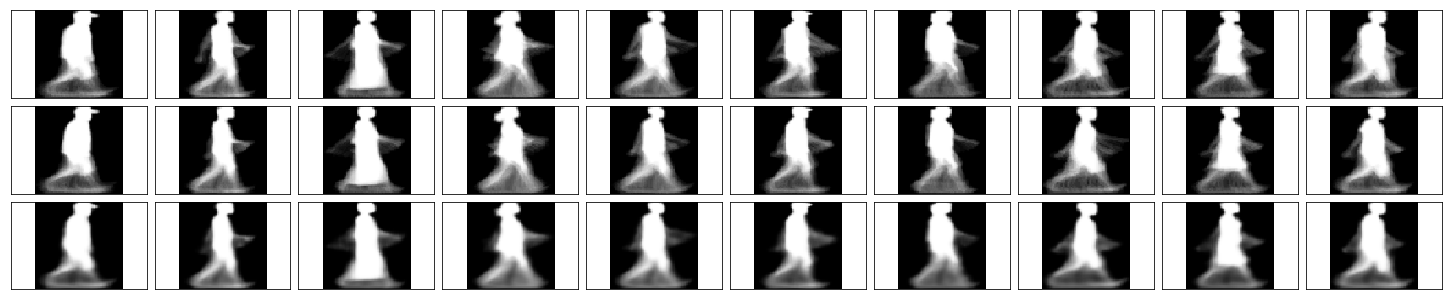

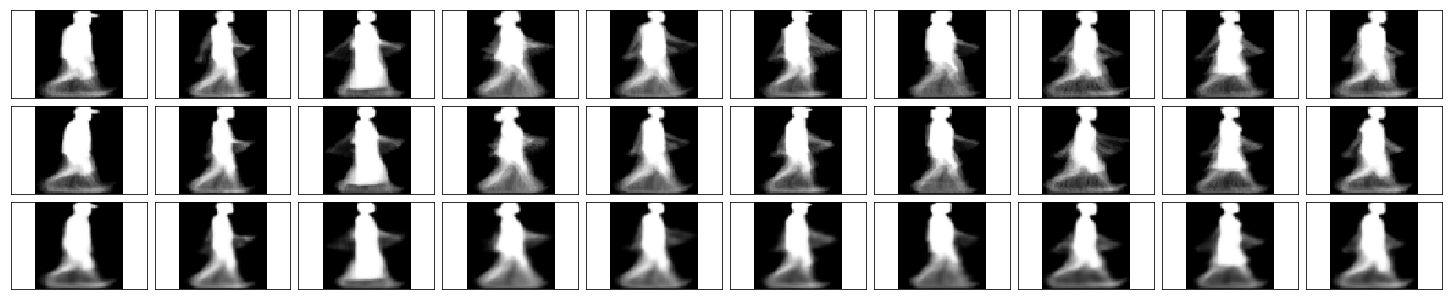

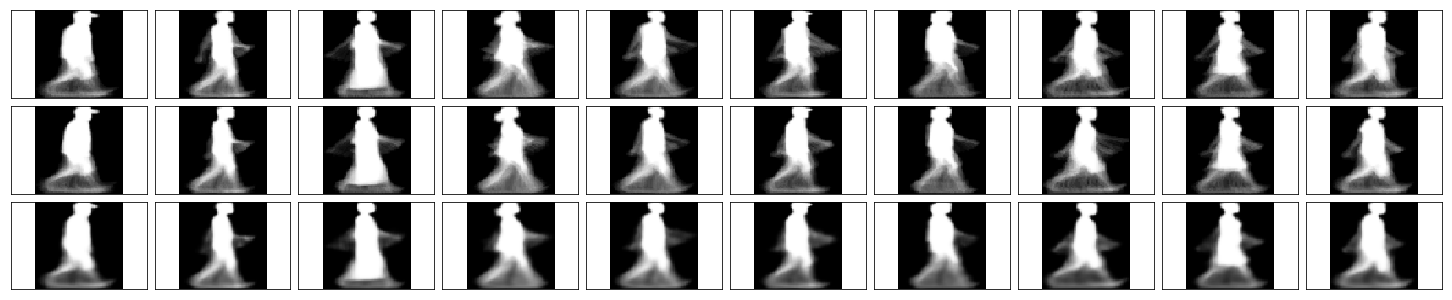

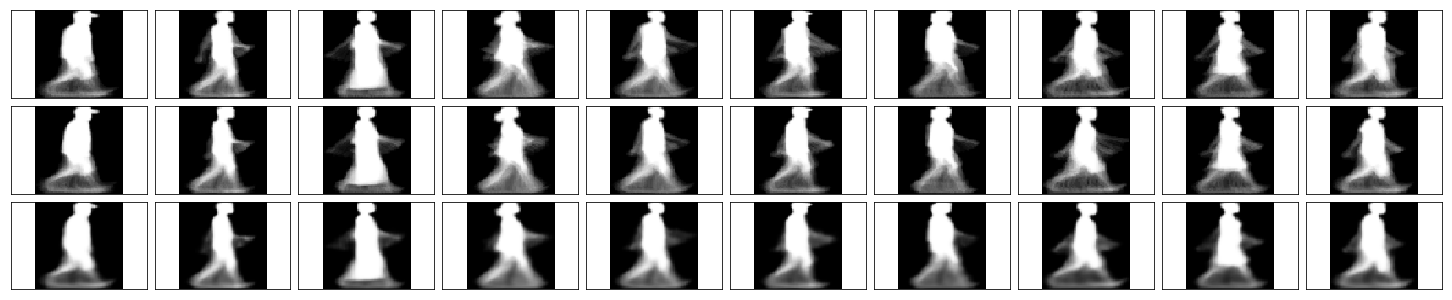

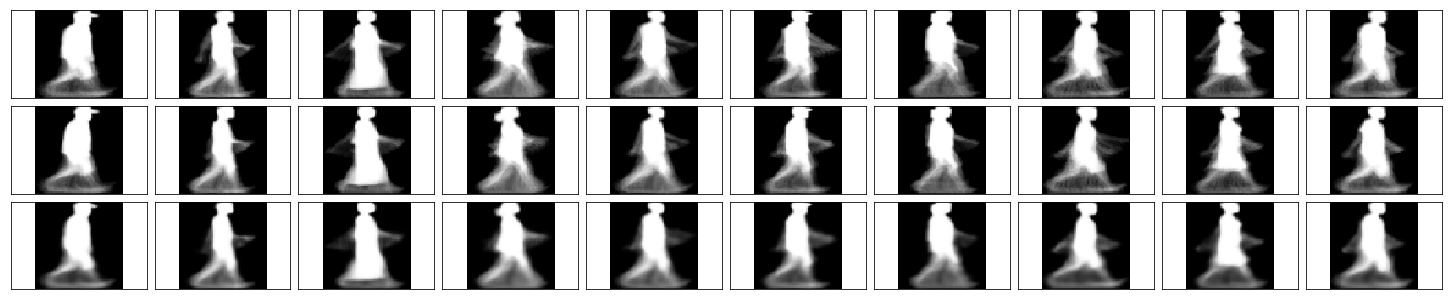

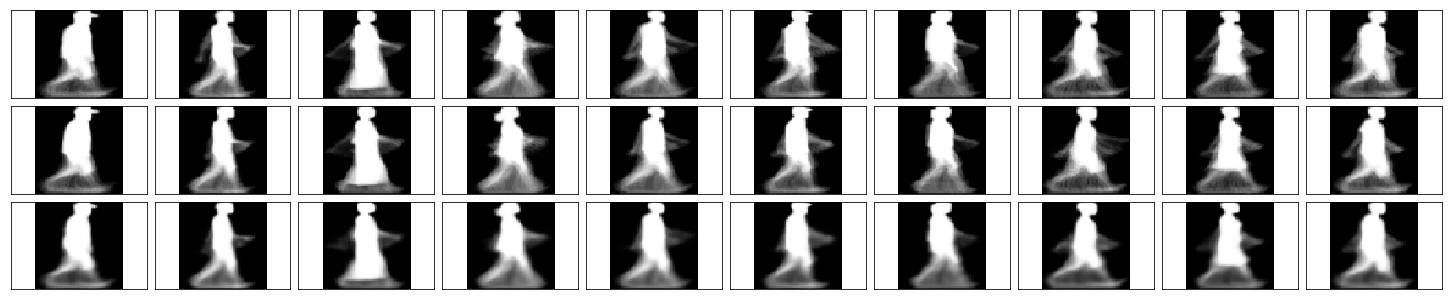

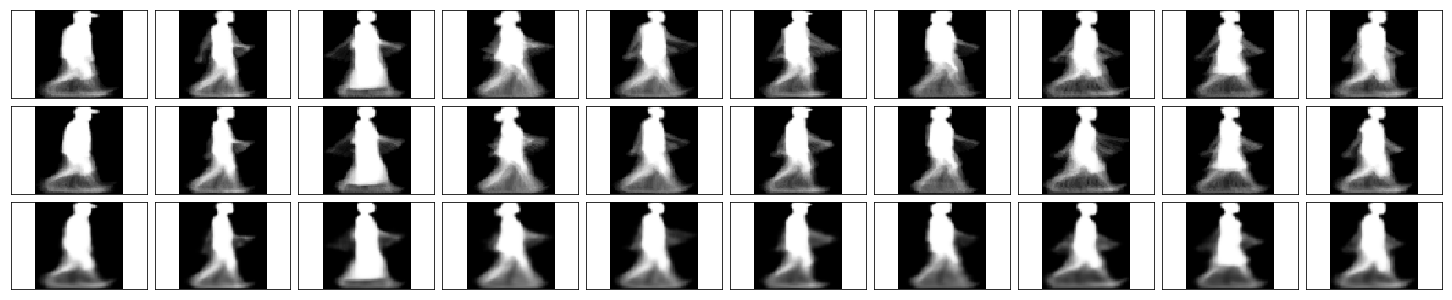

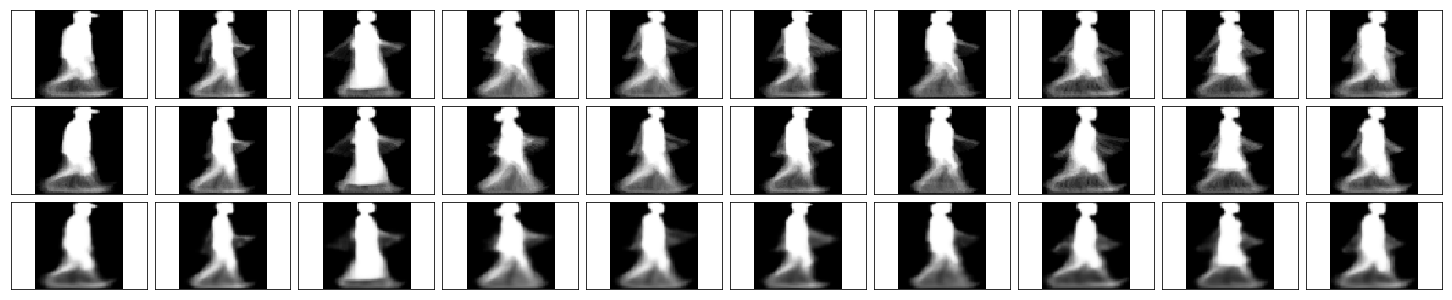

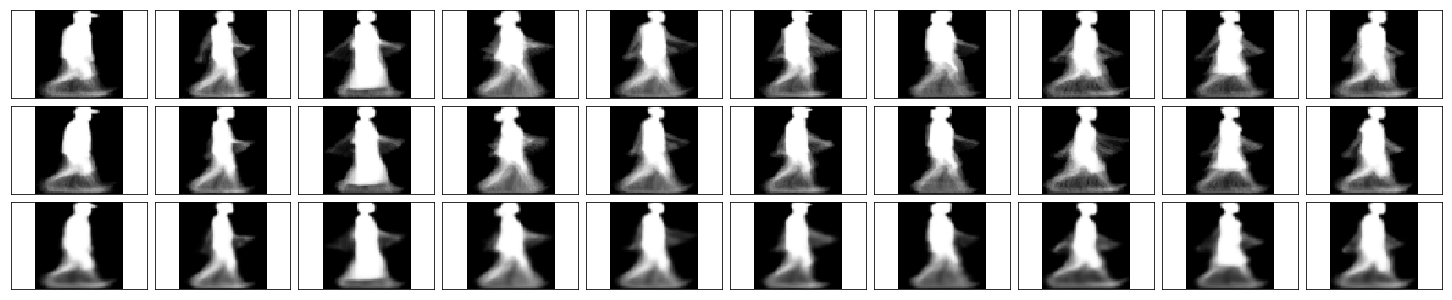

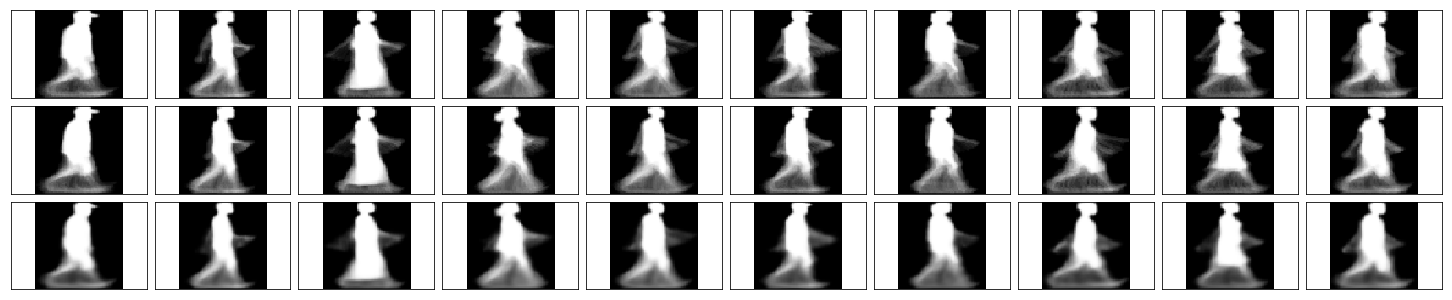

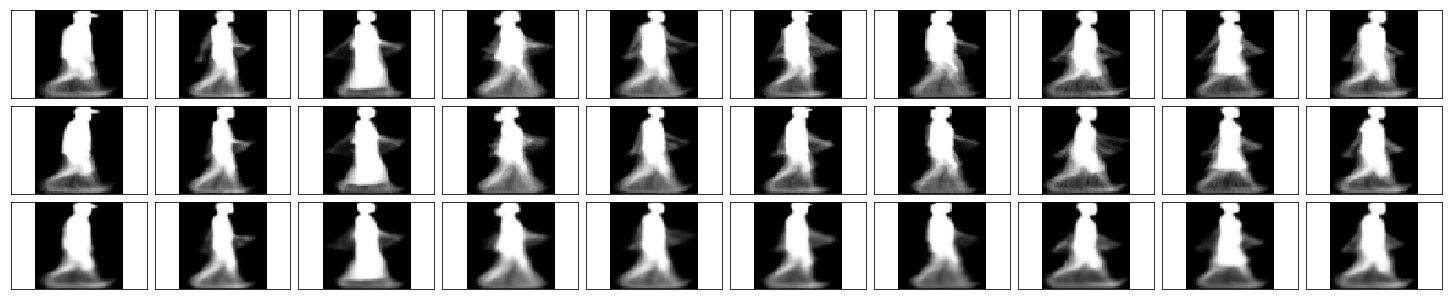

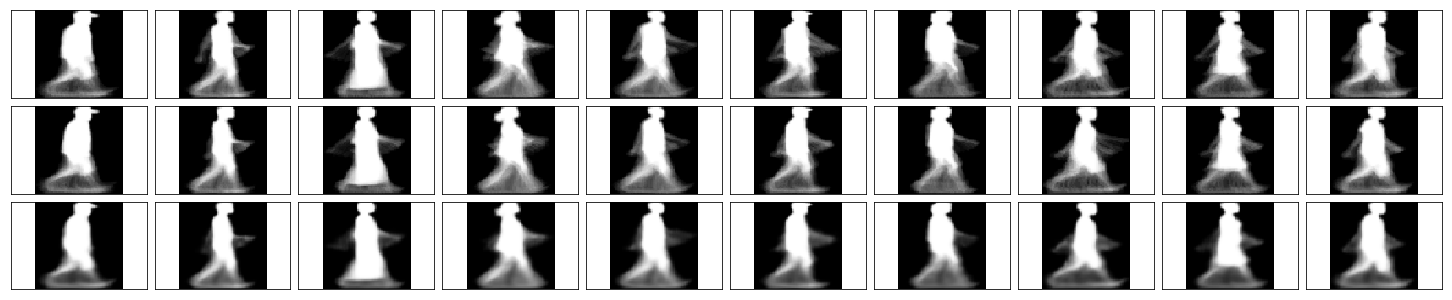

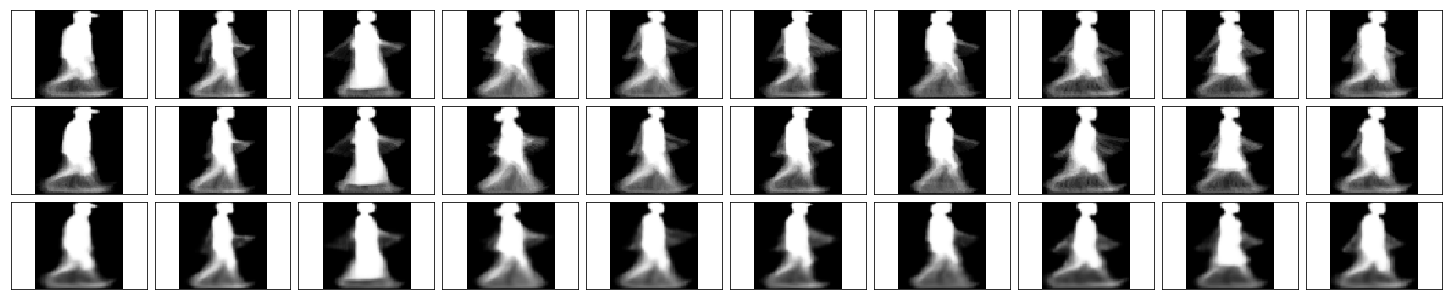

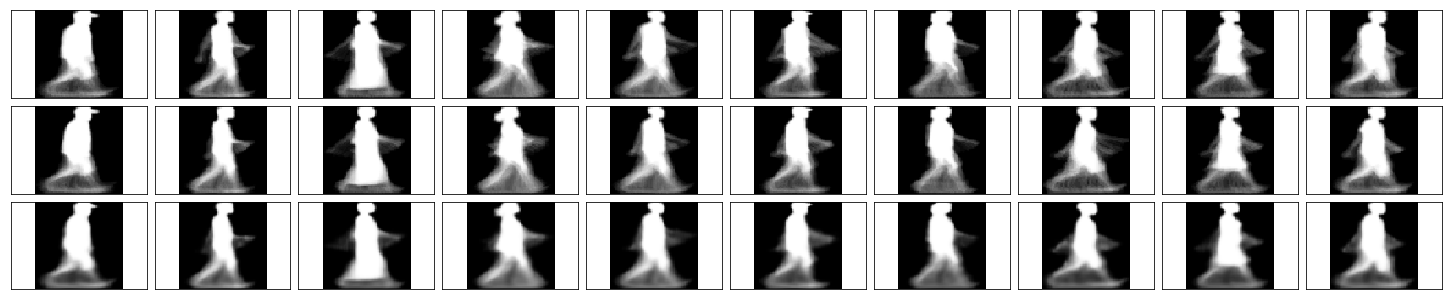

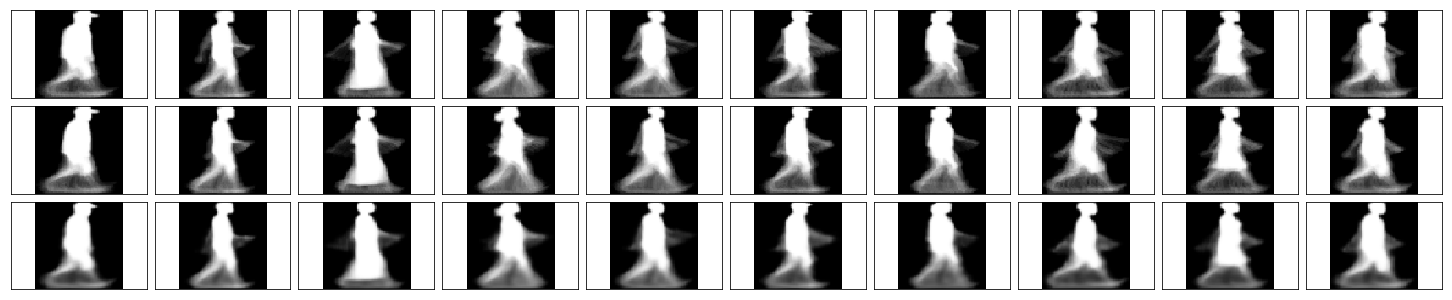

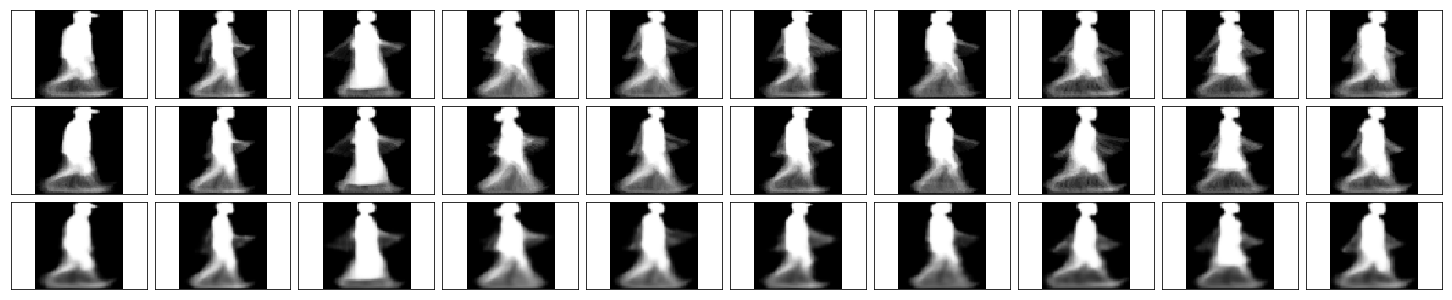

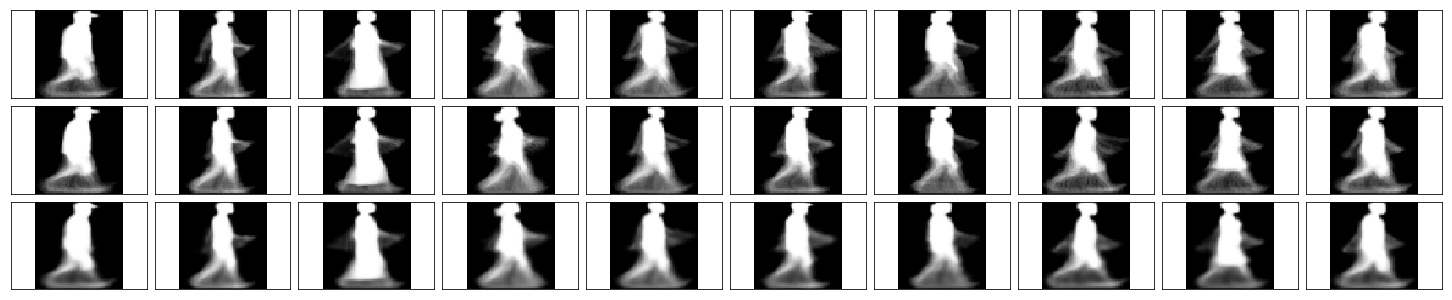

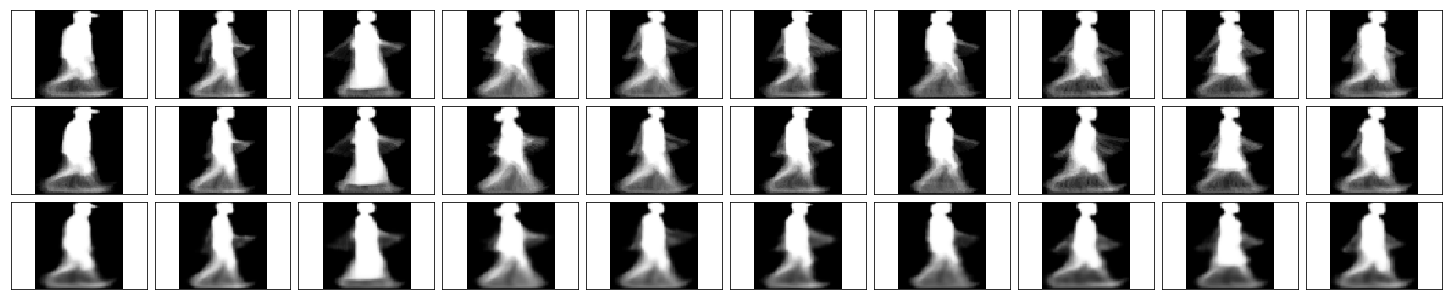

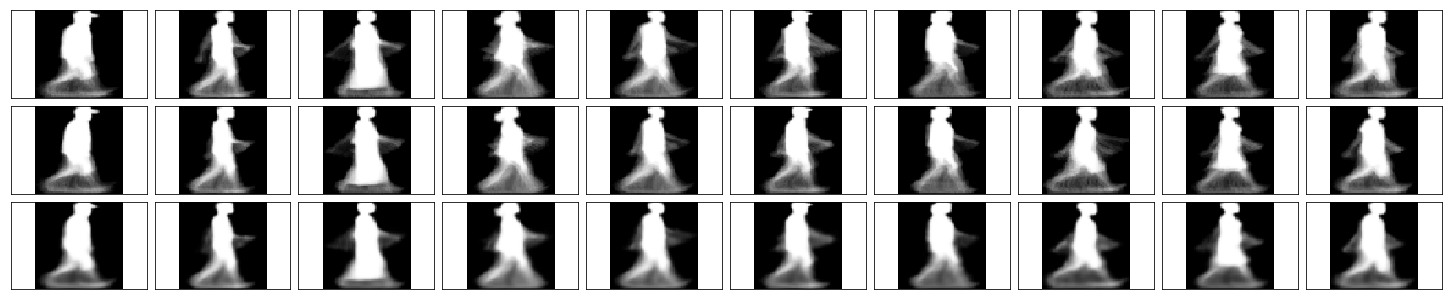

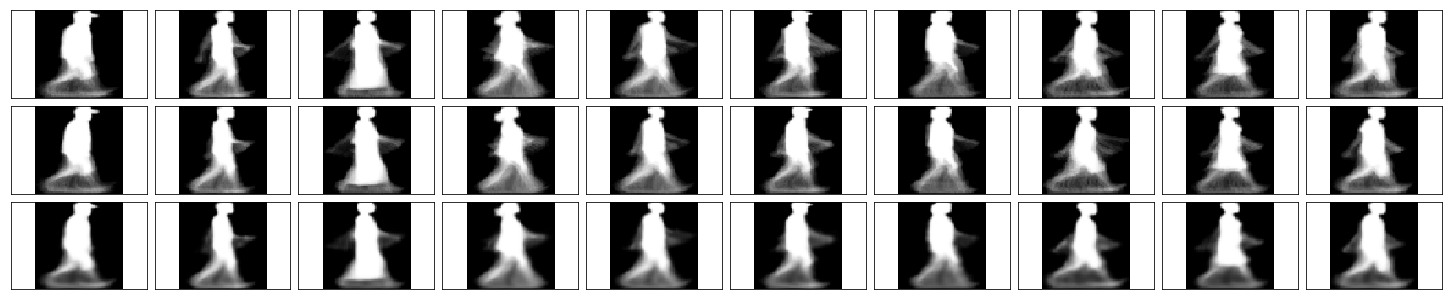

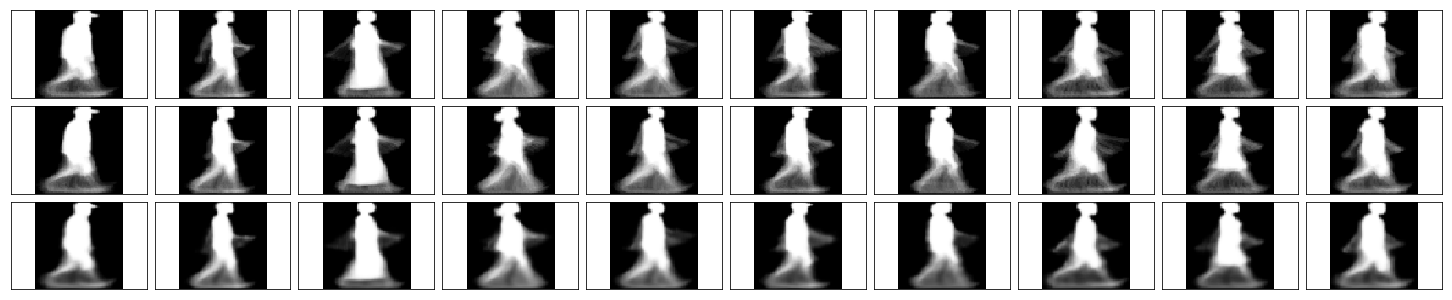

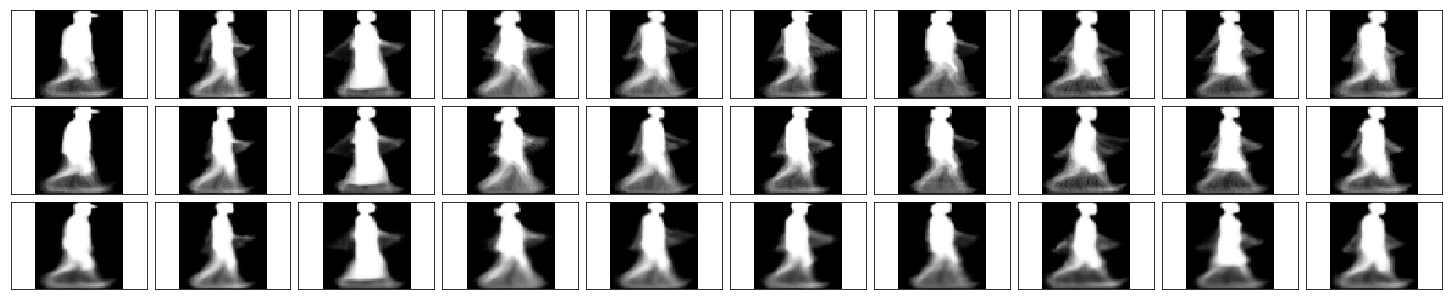

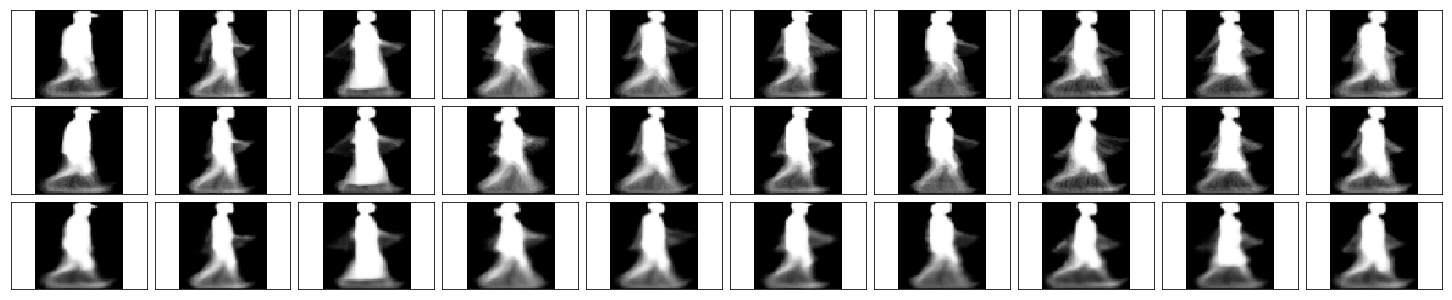

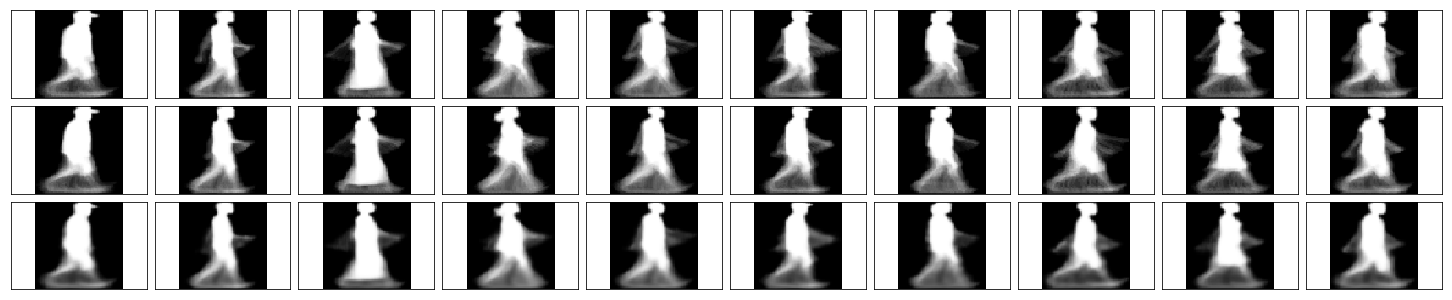

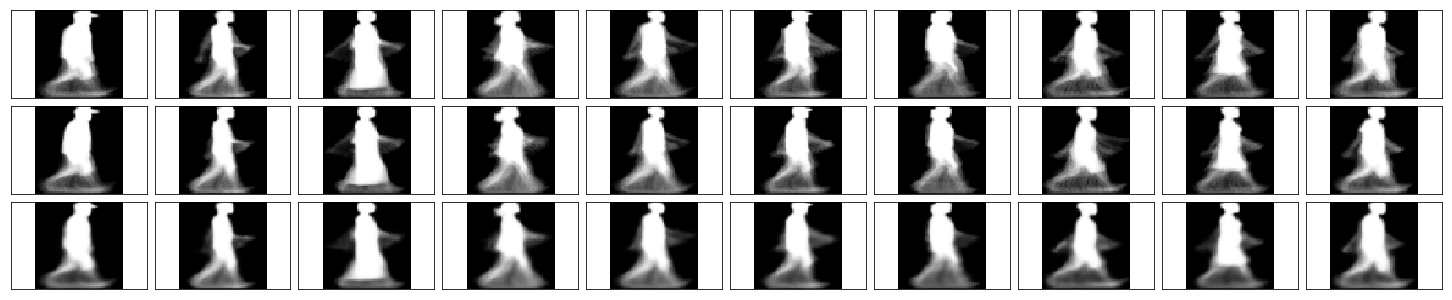

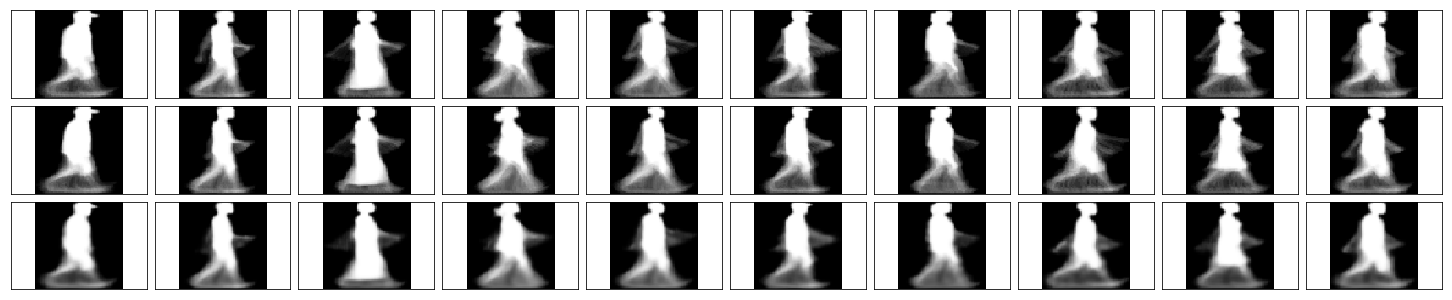

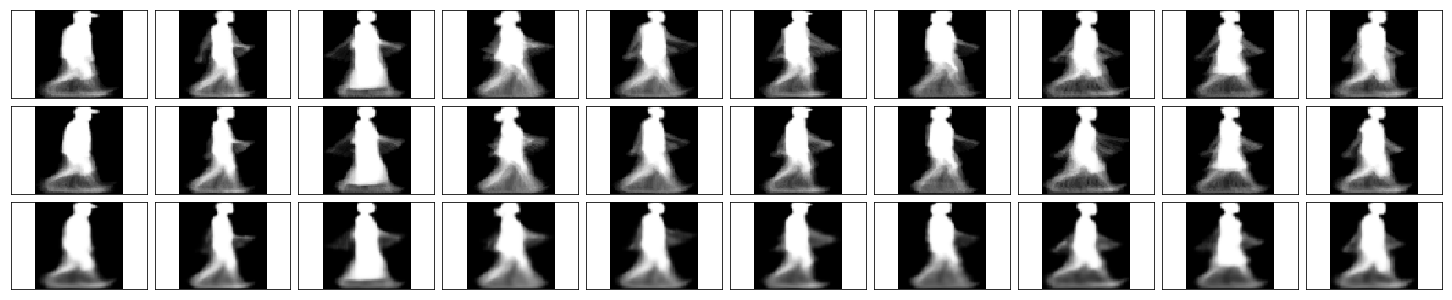

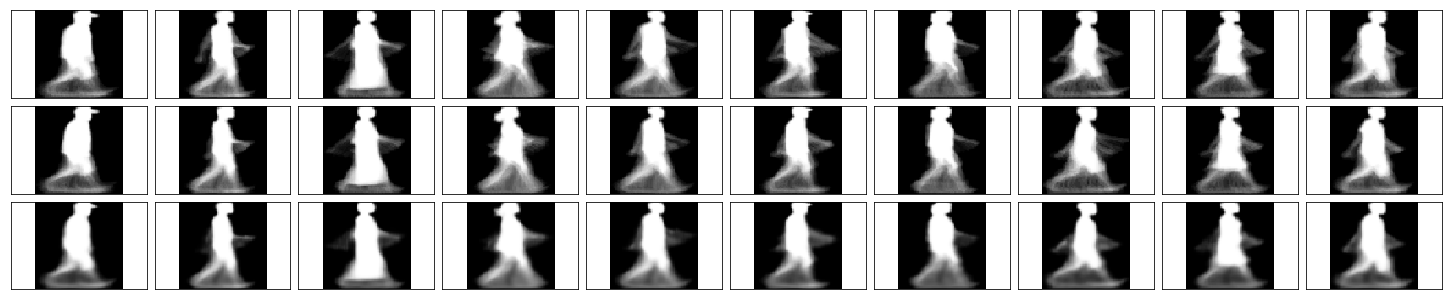

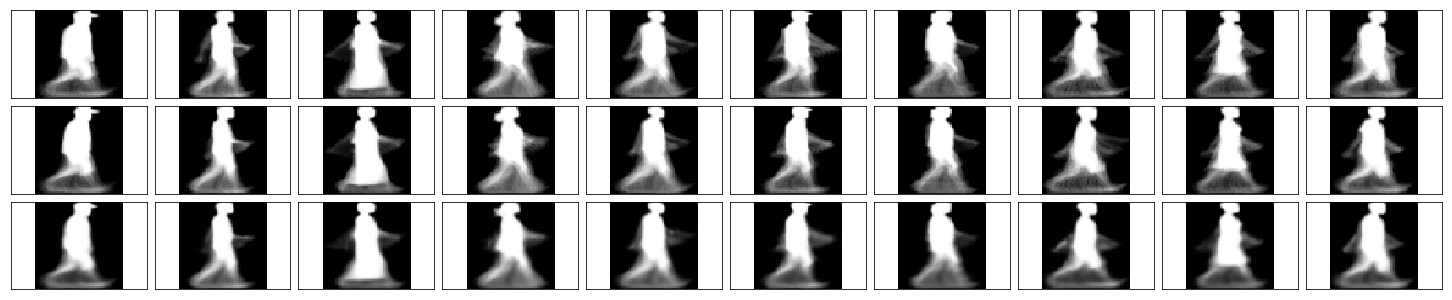

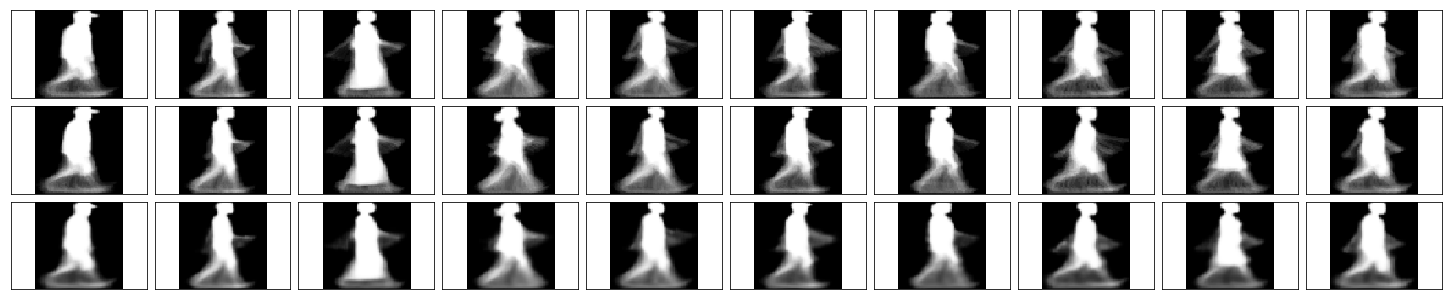

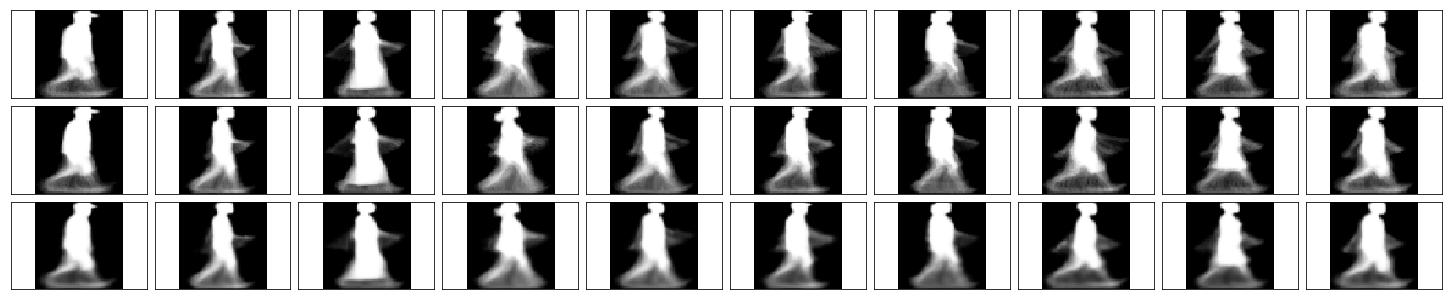

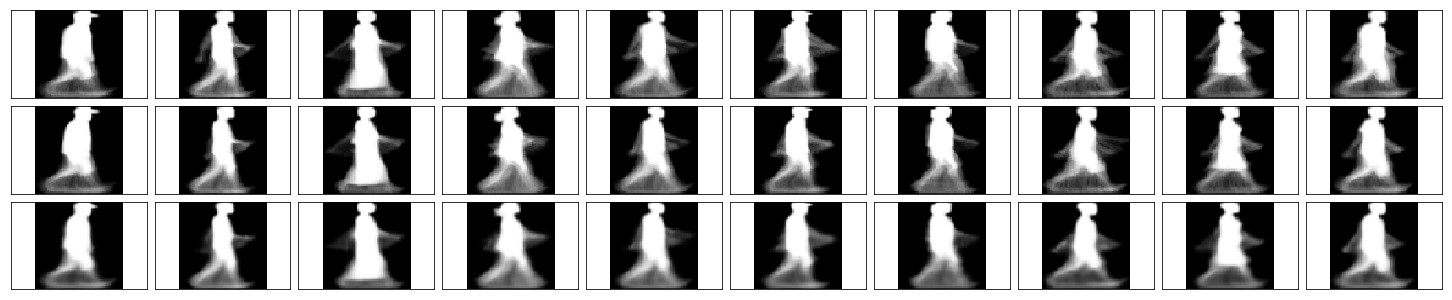

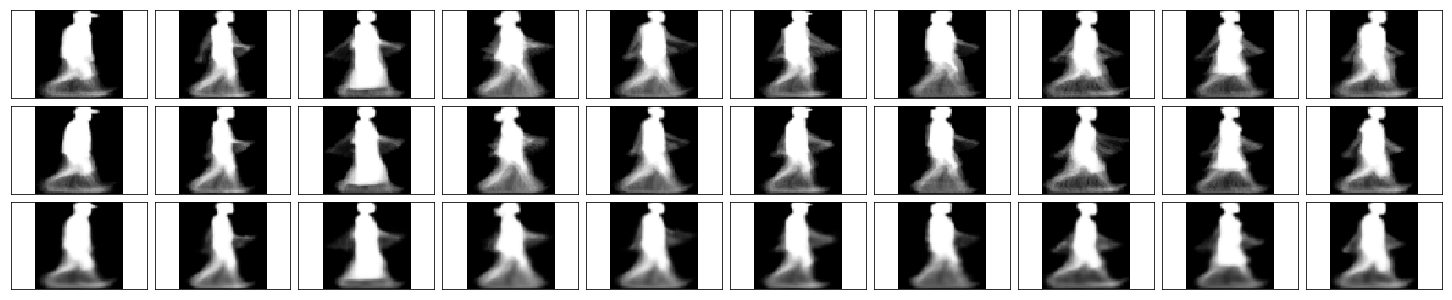

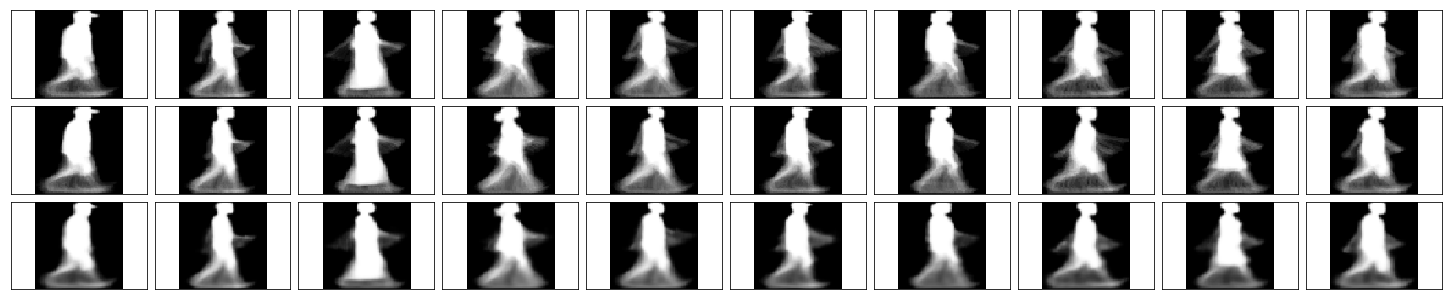

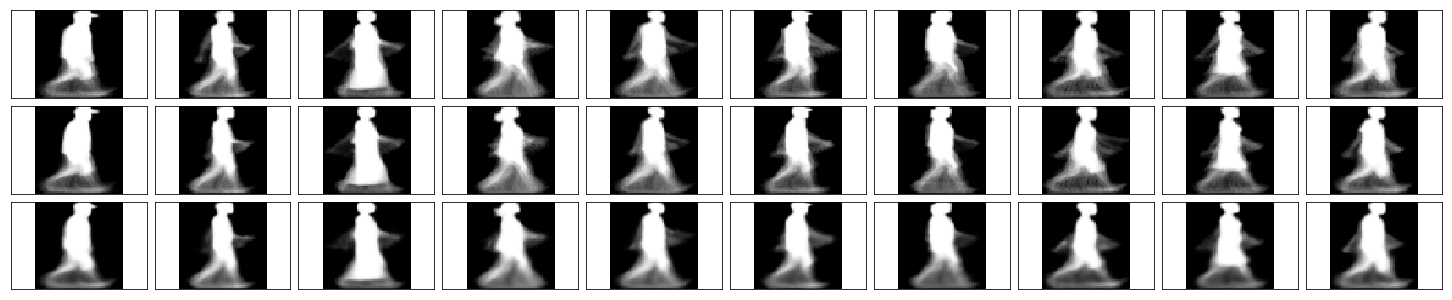

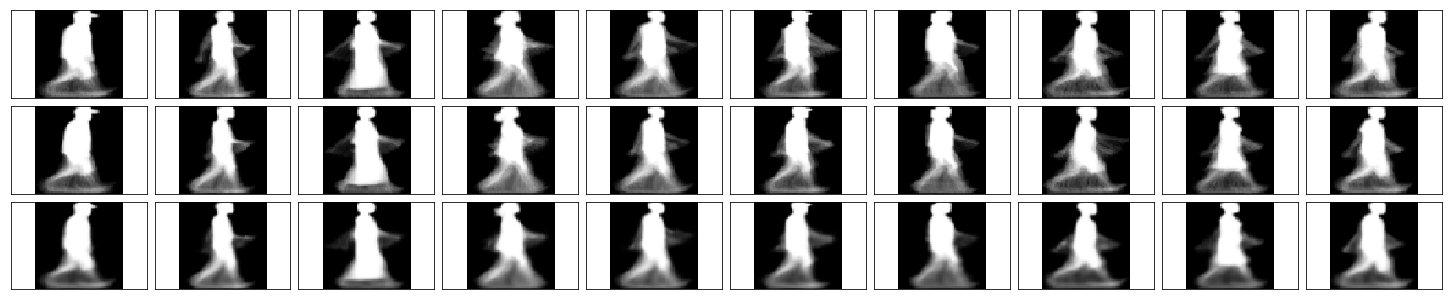

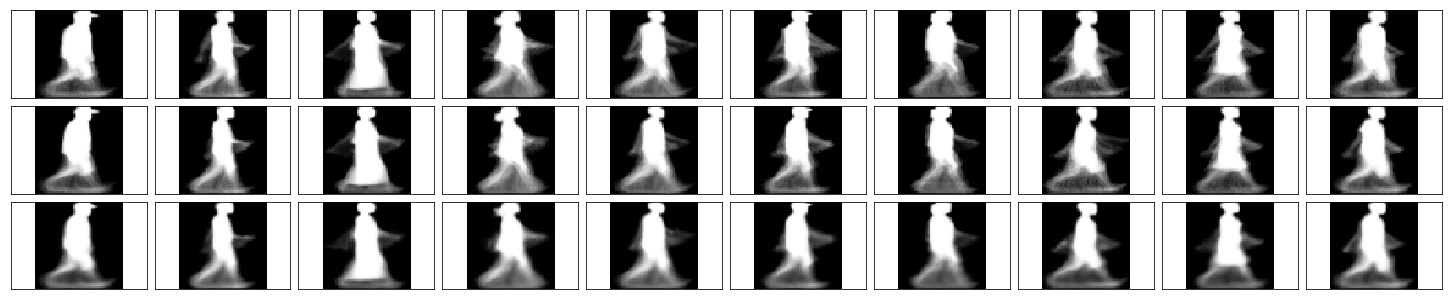

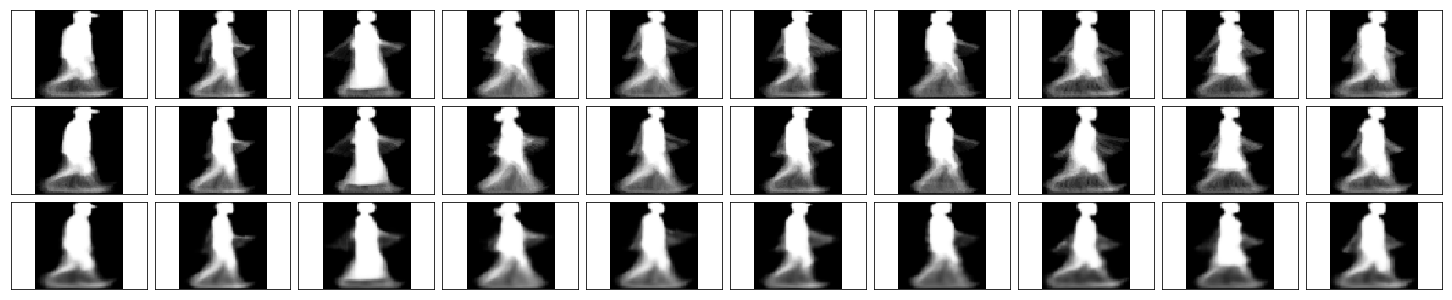

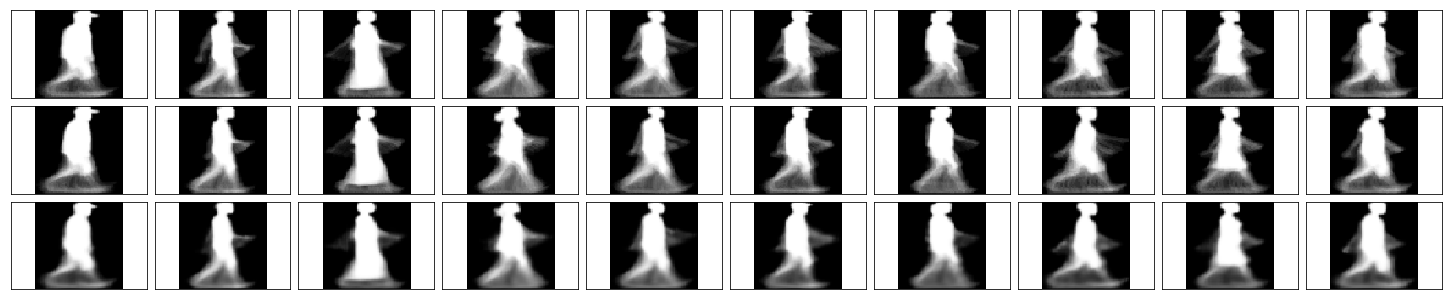

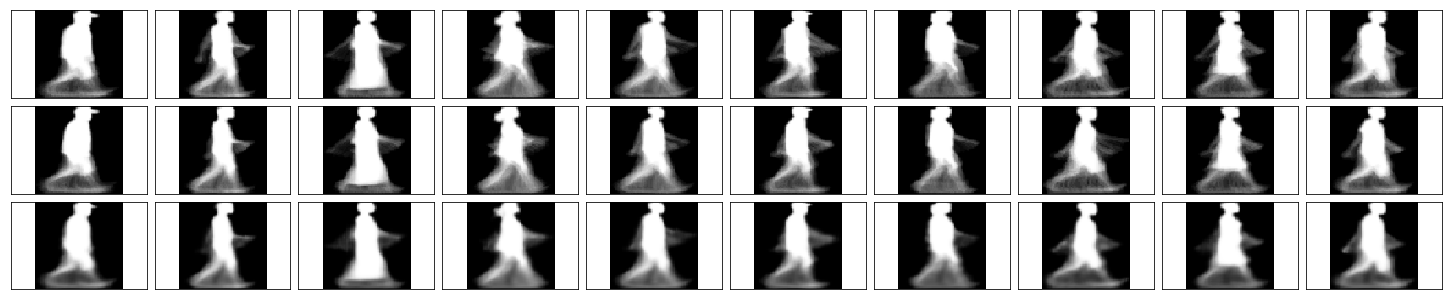

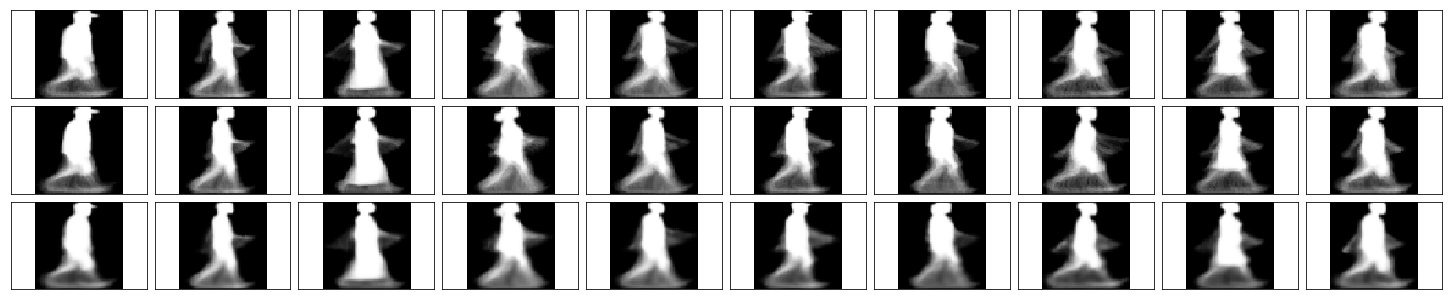

In [23]:
!mkdir checkpoints_view_invariant

Au = 2
num_layers = 2
epochs = 400
batch_size = 80
conv_kern_size = (4,4)
conv_strides = (1,1)
pool_size = (2,2)
pool_strides = (2,2)
up_size = [(32,32), (64,64)]
de_kern_size = (4,4)
de_conv_strides = (1,1)
out_kern_size = (4,4)
out_strides = (1,1)
std = 0.02

for lr in [0.001]:
#                 log_string = 'logs/4/lr={},nl={},ls={},bs={}'.format(lr, num_layers, lstm_size, batch_size)
    save_string = './checkpoints_view_invariant/Au={}_lr={}_nl={}_bs={}.ckpt'.format(Au, lr, num_layers, batch_size)
                
#             writer = tf.summary.FileWriter(log_string)
#     build_graph(kern_size, std, conv_strides, pool_size, pool_strides, de_kern_size, 
#                 de_conv_strides, out_kern_size, out_strides, up_size=[(16,16), (32,32), (64,64)], set_is_training=True):
    
    model = build_graph(conv_kern_size, std, conv_strides, pool_size, pool_strides, de_kern_size, de_conv_strides,
                        out_kern_size, out_strides, up_size=up_size)

    train(model, epochs, save_string)
                
    print(' ')
    print(' ')
    print("leraning_rate={},num_layers={},batch_size={} finished, saved".format(lr, num_layers, batch_size))
    print(' ')
    print(' ')

<br><br><br><br><br><br><br><br><br>

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [6]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

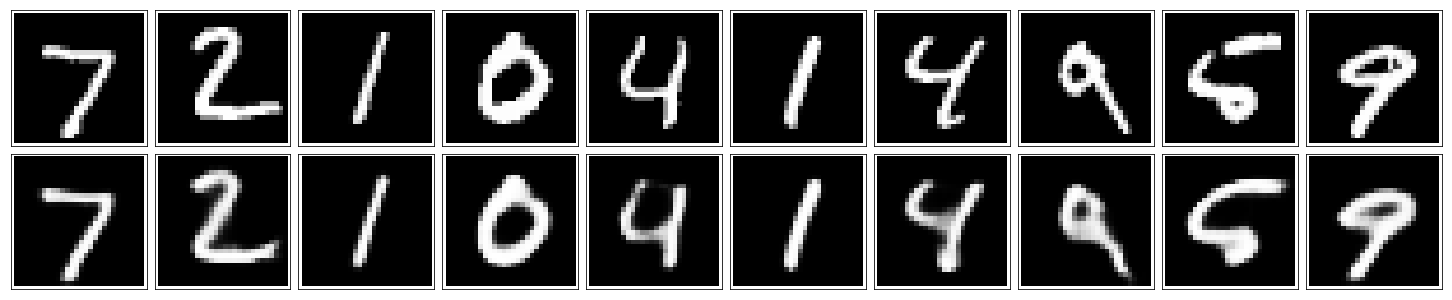

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [22]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

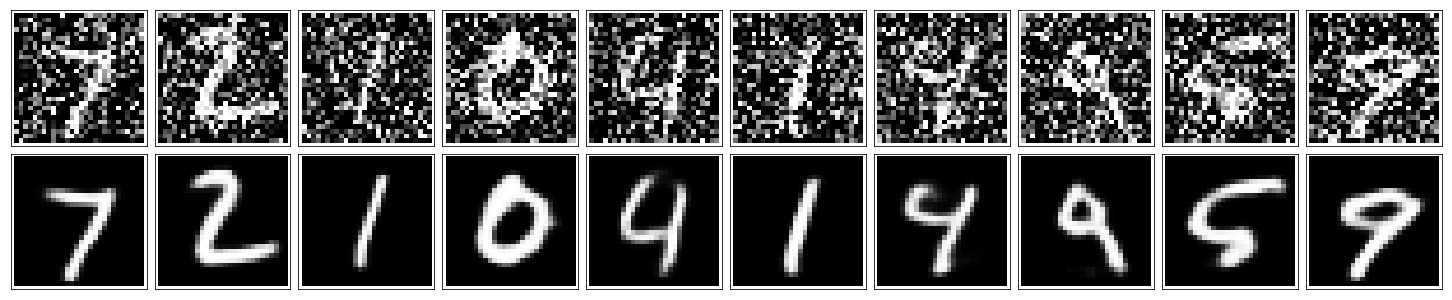

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)